#### IMPORTING NECESSARY LIBRARIES

In [154]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from tabulate import tabulate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings("ignore")



#### DATA LOADING

In [155]:
df = pd.read_csv('bitcoin_data.csv')
print("Loaded the data successfully!")

# Display the first few rows of the dataframe
df.head(10)

Loaded the data successfully!


,Price,Close,High,Low,Open,Volume
0,Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
1,Date,NaN,NaN,NaN,NaN,NaN
2,2022-08-15,24136.97265625,25135.58984375,23839.775390625,24318.31640625,35123501685
3,2022-08-16,23883.291015625,24228.416015625,23733.5,24126.13671875,27753685646
4,2022-08-17,23335.998046875,24407.05859375,23243.353515625,23881.31640625,30931623076
5,2022-08-18,23212.73828125,23563.83203125,23177.6015625,23341.0390625,23747613147
6,2022-08-19,20877.552734375,23213.3125,20868.84765625,23213.3125,40509610260
7,2022-08-20,21166.060546875,21350.806640625,20856.73046875,20872.841796875,27595671000
8,2022-08-21,21534.12109375,21668.845703125,21103.197265625,21160.392578125,23102307723
9,2022-08-22,21398.908203125,21531.462890625,20939.18359375,21531.462890625,31666498758


In [156]:
# Get the last 10 rows of the dataframe
df.tail(10)

,Price,Close,High,Low,Open,Volume
1086,2025-08-03,114217.671875,114747.421875,111943.8046875,112525.8046875,48099615826
1087,2025-08-04,115071.8828125,115729.46875,114130.40625,114223.921875,35783028986
1088,2025-08-05,114141.4453125,115117.4375,112701.109375,115072.1875,61039182286
1089,2025-08-06,115028.0,115737.8359375,113372.25,114140.9140625,56379133510
1090,2025-08-07,117496.8984375,117676.90625,114279.7109375,115030.0546875,64051649681
1091,2025-08-08,116688.7265625,117689.203125,115917.4609375,117505.5,59713005166
1092,2025-08-09,116500.359375,117906.609375,116363.8359375,116678.2734375,54004312429
1093,2025-08-10,119306.7578125,119320.7109375,116485.1640625,116497.71875,64755458694
1094,2025-08-11,118731.4453125,122321.09375,118159.03125,119306.8125,90528784177
1095,2025-08-14,122650.8671875,124210.625,122650.8671875,123339.765625,95469862912


#### DATA CLEANING

In [157]:
# Get the shape of the dataframe
print(f"Dataframe shape: {df.shape}")

# Get the column names and data types of the dataframe
print("Column names and data types:")
print(df.dtypes)

Dataframe shape: (1096, 6)
Column names and data types:
Price     object
Close     object
High      object
Low       object
Open      object
Volume    object
dtype: object


##### Our dataset has 1096 rows of data and 6 columns. All columns are of type object thus we proceed to cleaning the data and structuring it to the required format.

##### 1. Remove the first two rows and have the correct headers
##### 2. Convert the bitcoin currency columns to numeric float.
##### 3. Set the Data column as the index column for easy time series analysis.

In [158]:
# Drop the first two rows and reset the index
df = df.iloc[2:].reset_index(drop=True)
# Set the correct row names as the headers
df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
# Convert the 'Open', 'High', 'Low', 'Close', and 'Volume' columns to numeric, coercing errors
df[['Close', 'High', 'Low', 'Open', 'Volume']] = df[['Close', 'High', 'Low', 'Open', 'Volume']].astype(float)

print("Data cleaning completed successfully!")  
print(df.dtypes)

df.head(10)

Data cleaning completed successfully!
Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object


,Date,Open,High,Low,Close,Volume
0,2022-08-15,24136.972656,25135.589844,23839.775391,24318.316406,3.512350e+10
1,2022-08-16,23883.291016,24228.416016,23733.500000,24126.136719,2.775369e+10
2,2022-08-17,23335.998047,24407.058594,23243.353516,23881.316406,3.093162e+10
3,2022-08-18,23212.738281,23563.832031,23177.601562,23341.039062,2.374761e+10
4,2022-08-19,20877.552734,23213.312500,20868.847656,23213.312500,4.050961e+10
5,2022-08-20,21166.060547,21350.806641,20856.730469,20872.841797,2.759567e+10
6,2022-08-21,21534.121094,21668.845703,21103.197266,21160.392578,2.310231e+10
7,2022-08-22,21398.908203,21531.462891,20939.183594,21531.462891,3.166650e+10
8,2022-08-23,21528.087891,21646.203125,20955.138672,21401.044922,3.187828e+10
9,2022-08-24,21395.019531,21783.076172,21195.005859,21526.455078,3.196225e+10


In [159]:
# Setting date as index for time series analysis
df.set_index('Date', inplace=True)
# Display the first few rows of the dataframe after cleaning
df.head(10)

,Open,High,Low,Close,Volume
Date,,,,,
2022-08-15,24136.972656,25135.589844,23839.775391,24318.316406,3.512350e+10
2022-08-16,23883.291016,24228.416016,23733.500000,24126.136719,2.775369e+10
2022-08-17,23335.998047,24407.058594,23243.353516,23881.316406,3.093162e+10
2022-08-18,23212.738281,23563.832031,23177.601562,23341.039062,2.374761e+10
2022-08-19,20877.552734,23213.312500,20868.847656,23213.312500,4.050961e+10
2022-08-20,21166.060547,21350.806641,20856.730469,20872.841797,2.759567e+10
2022-08-21,21534.121094,21668.845703,21103.197266,21160.392578,2.310231e+10
2022-08-22,21398.908203,21531.462891,20939.183594,21531.462891,3.166650e+10
2022-08-23,21528.087891,21646.203125,20955.138672,21401.044922,3.187828e+10


In [160]:
# Checking for missing values, duplicated values, and data types
print("Checking for missing values:")
print(df.isnull().sum())
print("\nChecking for duplicated values:")
print(df.duplicated().sum())
print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")                    

Checking for missing values:
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

Checking for duplicated values:
0
Date range: 2022-08-15 to 2025-08-14


#### EXPLANATORY DATA ANALYSIS

In [161]:
# Get the summary statistics of the dataframe
print("Summary statistics:")
df.describe()

Summary statistics:


,Open,High,Low,Close,Volume
count,1094.000000,1094.000000,1094.000000,1094.000000,1.094000e+03
mean,54530.030357,55426.550472,53488.088224,54444.186930,3.248661e+10
std,30923.339262,31405.484388,30341.907989,30877.483035,2.122987e+10
min,15787.284180,16253.047852,15599.046875,15782.300781,5.331173e+09
25%,26836.914062,27153.494141,26501.779785,26825.105957,1.720742e+10
50%,49850.332031,50319.433594,48076.128906,49014.916016,2.742436e+10
75%,78452.621094,81385.582031,76091.964844,77859.888672,4.138676e+10
max,122650.867188,124210.625000,122650.867188,123339.765625,1.817464e+11


##### The Bitcoin dataset captures an extraordinary period of market volatility from August 2022 to August 2025, with prices ranging from $15,782 to $123,339 - representing a massive 680% swing that demonstrates Bitcoin's extreme price volatility. The data shows a right-skewed distribution (mean $54,444 > median $49,014), indicating more frequent extreme upward price movements, while the high standard deviation of ~$30,877 reveals that Bitcoin experienced significant daily price swings throughout this period. This dataset is ideal for forecasting analysis because it captures multiple market cycles including the crypto winter of 2022, recovery phases, and recent all-time highs, providing rich patterns for different forecasting models to learn from.

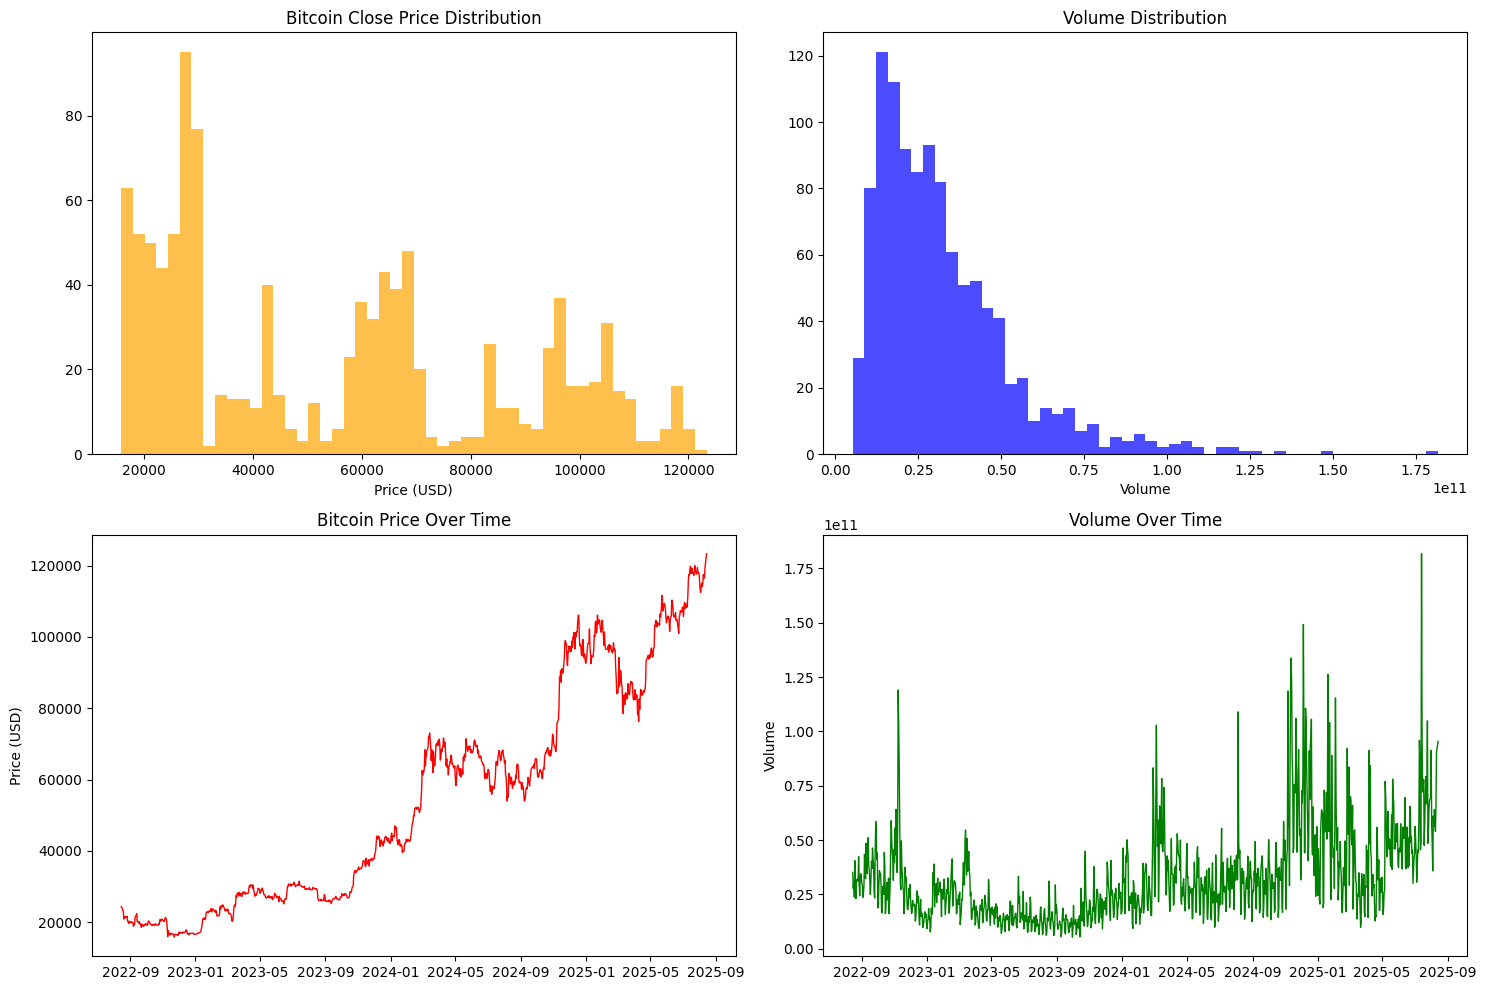

=== RETURN ANALYSIS ===
Average daily return: 0.0018 (0.18%)
Daily volatility: 0.0256 (2.56%)
Annualized volatility: 40.65%


In [162]:

# 1. Price Distribution Analysis
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Close price distribution
axes[0,0].hist(df['Close'], bins=50, alpha=0.7, color='orange')
axes[0,0].set_title('Bitcoin Close Price Distribution')
axes[0,0].set_xlabel('Price (USD)')

# Volume distribution  
axes[0,1].hist(df['Volume'], bins=50, alpha=0.7, color='blue')
axes[0,1].set_title('Volume Distribution')
axes[0,1].set_xlabel('Volume')

# Price over time
axes[1,0].plot(df.index, df['Close'], color='red', linewidth=1)
axes[1,0].set_title('Bitcoin Price Over Time')
axes[1,0].set_ylabel('Price (USD)')

# Volume over time
axes[1,1].plot(df.index, df['Volume'], color='green', linewidth=1)
axes[1,1].set_title('Volume Over Time')
axes[1,1].set_ylabel('Volume')

plt.tight_layout()
plt.show()

# 2. Calculate and analyze returns
df['Daily_Return'] = df['Close'].pct_change()
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

print("=== RETURN ANALYSIS ===")
print(f"Average daily return: {df['Daily_Return'].mean():.4f} ({df['Daily_Return'].mean()*100:.2f}%)")
print(f"Daily volatility: {df['Daily_Return'].std():.4f} ({df['Daily_Return'].std()*100:.2f}%)")
print(f"Annualized volatility: {df['Daily_Return'].std() * np.sqrt(252):.2%}")

##### Price Behavior: Bitcoin shows a clear bimodal distribution, spending significant time around $20K-25K during the bear market period and $60K-70K during bull phases. The price chart reveals a dramatic journey from lows around $17K in late 2022 to highs above $100K in 2025, representing a massive 6x increase over the 3-year period.
##### Trading Volume Patterns: Volume distribution is heavily right-skewed, meaning most trading days have relatively low volume with occasional explosive spikes. These volume surges typically coincide with major price movements, suggesting that high trading activity often signals significant market events or trend changes.
##### Market Phases: The data captures a complete market cycle - from bear market bottoms through consolidation periods to explosive bull market growth. The recent parabolic price movement shows Bitcoin entered a major bull phase, which could present both opportunities and challenges for our forecasting models.
##### Forecasting Implications: This dataset presents interesting challenges including regime changes (different market phases), high volatility, and non-stationary trends. However, the clear trending behavior and volume-price relationships provide valuable signals that our forecasting models can potentially exploit to make accurate predictions.

=== DAILY RETURNS STATISTICS ===
Mean daily return: 0.0018 (0.18%)
Median daily return: 0.0002 (0.02%)
Standard deviation: 0.0256 (2.56%)
Annualized volatility: 40.65%
Skewness: 0.274
Kurtosis: 3.752

=== EXTREME MOVEMENTS ===
Best day: 12.17% on 2024-08-09
Worst day: -14.35% on 2022-11-10
Days with >10% moves: 6
Days with >5% moves: 66


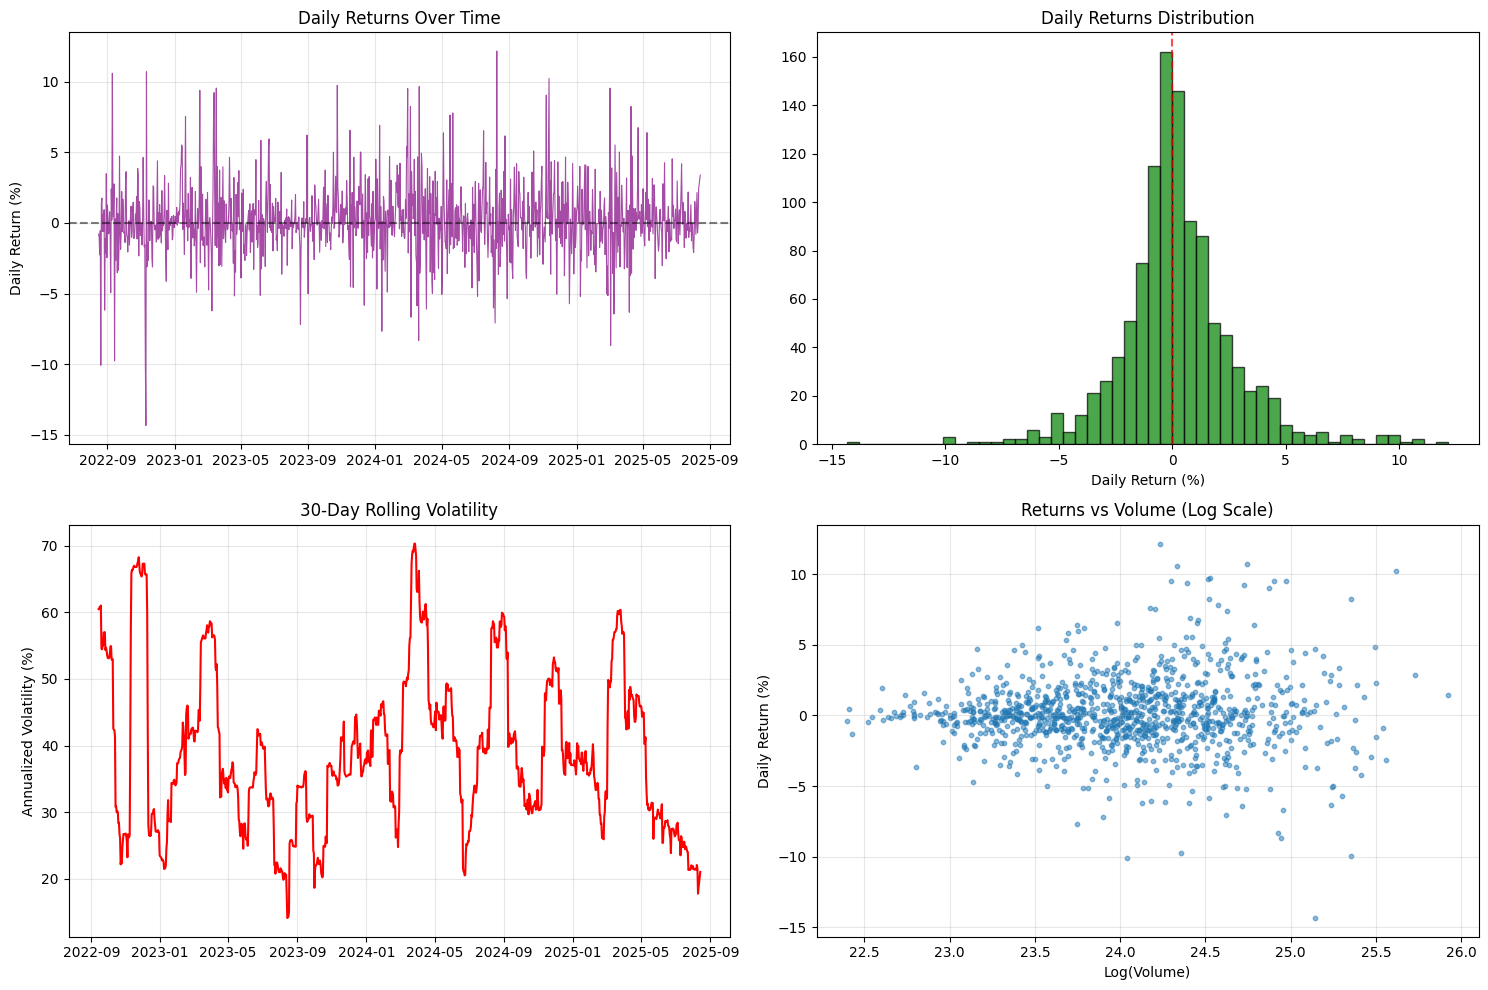


=== VOLATILITY CLUSTERING ===
High volatility periods (>75th percentile): 266 days
Correlation between returns and log(volume): 0.032


In [163]:
# Calculate returns
df['Daily_Return'] = df['Close'].pct_change()

# Remove first row (NaN due to pct_change)
returns = df['Daily_Return'].dropna()

print("=== DAILY RETURNS STATISTICS ===")
print(f"Mean daily return: {returns.mean():.4f} ({returns.mean()*100:.2f}%)")
print(f"Median daily return: {returns.median():.4f} ({returns.median()*100:.2f}%)")
print(f"Standard deviation: {returns.std():.4f} ({returns.std()*100:.2f}%)")
print(f"Annualized volatility: {returns.std() * np.sqrt(252):.2%}")
print(f"Skewness: {returns.skew():.3f}")
print(f"Kurtosis: {returns.kurtosis():.3f}")

# Extreme movements
print(f"\n=== EXTREME MOVEMENTS ===")
print(f"Best day: {returns.max():.2%} on {returns.idxmax().date()}")
print(f"Worst day: {returns.min():.2%} on {returns.idxmin().date()}")
print(f"Days with >10% moves: {(abs(returns) > 0.10).sum()}")
print(f"Days with >5% moves: {(abs(returns) > 0.05).sum()}")

# Create comprehensive returns visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Returns over time
axes[0,0].plot(returns.index, returns*100, color='purple', alpha=0.7, linewidth=0.8)
axes[0,0].set_title('Daily Returns Over Time')
axes[0,0].set_ylabel('Daily Return (%)')
axes[0,0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[0,0].grid(True, alpha=0.3)

# 2. Returns distribution
axes[0,1].hist(returns*100, bins=50, alpha=0.7, color='green', edgecolor='black')
axes[0,1].set_title('Daily Returns Distribution')
axes[0,1].set_xlabel('Daily Return (%)')
axes[0,1].axvline(x=0, color='red', linestyle='--', alpha=0.7)

# 3. Rolling volatility (30-day)
rolling_vol = returns.rolling(window=30).std() * np.sqrt(252) * 100
axes[1,0].plot(rolling_vol.index, rolling_vol, color='red', linewidth=1.5)
axes[1,0].set_title('30-Day Rolling Volatility')
axes[1,0].set_ylabel('Annualized Volatility (%)')
axes[1,0].grid(True, alpha=0.3)

# 4. Returns vs Volume relationship
# Use log scale for volume to handle large numbers
axes[1,1].scatter(np.log(df['Volume']), df['Daily_Return']*100, alpha=0.5, s=10)
axes[1,1].set_title('Returns vs Volume (Log Scale)')
axes[1,1].set_xlabel('Log(Volume)')
axes[1,1].set_ylabel('Daily Return (%)')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Volatility clustering analysis
print(f"\n=== VOLATILITY CLUSTERING ===")
high_vol_periods = rolling_vol > rolling_vol.quantile(0.75)
print(f"High volatility periods (>75th percentile): {high_vol_periods.sum()} days")

# Calculate correlation with volume
aligned_volume = df['Volume'][1:]  # Skip first row to match returns
vol_corr = np.corrcoef(np.log(aligned_volume), returns)[0,1]
print(f"Correlation between returns and log(volume): {vol_corr:.3f}")

##### High Risk Asset: 40.65% annualized volatility is extremely high (stocks are typically 15-20%). This confirms Bitcoin is a high-risk investment with potential for massive gains/losses.
##### Fat Tails & Extreme Events: 6 days with >10% moves and 66 days with >5% moves shows Bitcoin has frequent extreme events. The positive skewness (0.274) means slightly more extreme up moves than down moves.
##### Volatility Clustering: The rolling volatility chart clearly shows periods where high volatility clusters together (like 2022-2023 crisis period). This is crucial for our forecasting models.
##### Volume Insights: Weak correlation (0.032) between volume and returns suggests volume alone won't predict price direction, but the scatter plot shows some interesting patterns during extreme moves.

In [164]:
df.to_csv('bitcoin_data_clean.csv')
print("Clean data saved as 'bitcoin_data_clean.csv'")
print(f"File saved with {len(df)} rows and columns: {list(df.columns)}")
print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")

Clean data saved as 'bitcoin_data_clean.csv'
File saved with 1094 rows and columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 'Log_Return']
Date range: 2022-08-15 to 2025-08-14


#### DATA MODELLING

In [165]:
# Set up the target variable (next day's close price)
df['target'] = df['Close'].shift(-1)

print(f"Target created - predicting next day's close price")
print(f" Missing values in target: {df['target'].isnull().sum()}")
print("\nSample:")
print(df[['Close', 'target']].head())
# Display the first few rows to confirm target variable setup
df.head(10)



Target created - predicting next day's close price
 Missing values in target: 1

Sample:
                   Close        target
Date                                  
2022-08-15  24318.316406  24126.136719
2022-08-16  24126.136719  23881.316406
2022-08-17  23881.316406  23341.039062
2022-08-18  23341.039062  23213.312500
2022-08-19  23213.312500  20872.841797


,Open,High,Low,Close,Volume,Daily_Return,Log_Return,target
Date,,,,,,,,
2022-08-15,24136.972656,25135.589844,23839.775391,24318.316406,3.512350e+10,NaN,NaN,24126.136719
2022-08-16,23883.291016,24228.416016,23733.500000,24126.136719,2.775369e+10,-0.007903,-0.007934,23881.316406
2022-08-17,23335.998047,24407.058594,23243.353516,23881.316406,3.093162e+10,-0.010148,-0.010199,23341.039062
2022-08-18,23212.738281,23563.832031,23177.601562,23341.039062,2.374761e+10,-0.022623,-0.022883,23213.312500
2022-08-19,20877.552734,23213.312500,20868.847656,23213.312500,4.050961e+10,-0.005472,-0.005487,20872.841797
2022-08-20,21166.060547,21350.806641,20856.730469,20872.841797,2.759567e+10,-0.100825,-0.106277,21160.392578
2022-08-21,21534.121094,21668.845703,21103.197266,21160.392578,2.310231e+10,0.013776,0.013682,21531.462891
2022-08-22,21398.908203,21531.462891,20939.183594,21531.462891,3.166650e+10,0.017536,0.017384,21401.044922
2022-08-23,21528.087891,21646.203125,20955.138672,21401.044922,3.187828e+10,-0.006057,-0.006076,21526.455078


In [166]:


df.head(10)

,Open,High,Low,Close,Volume,Daily_Return,Log_Return,target
Date,,,,,,,,
2022-08-15,24136.972656,25135.589844,23839.775391,24318.316406,3.512350e+10,NaN,NaN,24126.136719
2022-08-16,23883.291016,24228.416016,23733.500000,24126.136719,2.775369e+10,-0.007903,-0.007934,23881.316406
2022-08-17,23335.998047,24407.058594,23243.353516,23881.316406,3.093162e+10,-0.010148,-0.010199,23341.039062
2022-08-18,23212.738281,23563.832031,23177.601562,23341.039062,2.374761e+10,-0.022623,-0.022883,23213.312500
2022-08-19,20877.552734,23213.312500,20868.847656,23213.312500,4.050961e+10,-0.005472,-0.005487,20872.841797
2022-08-20,21166.060547,21350.806641,20856.730469,20872.841797,2.759567e+10,-0.100825,-0.106277,21160.392578
2022-08-21,21534.121094,21668.845703,21103.197266,21160.392578,2.310231e+10,0.013776,0.013682,21531.462891
2022-08-22,21398.908203,21531.462891,20939.183594,21531.462891,3.166650e+10,0.017536,0.017384,21401.044922
2022-08-23,21528.087891,21646.203125,20955.138672,21401.044922,3.187828e+10,-0.006057,-0.006076,21526.455078


In [167]:
# Feature engineering using OHLCV data
print("Creating comprehensive features using OHLCV data...")

# Price lag features
df['close_lag_1'] = df['Close'].shift(1)
df['close_lag_2'] = df['Close'].shift(2)
df['open_lag_1'] = df['Open'].shift(1)
df['high_lag_1'] = df['High'].shift(1)
df['low_lag_1'] = df['Low'].shift(1)

# Volume features
df['volume_lag_1'] = df['Volume'].shift(1)
df['volume_ratio'] = df['Volume'] / df['Volume'].rolling(5).mean()

# Technical features
df['daily_range'] = df['High'] - df['Low']
df['price_position'] = (df['Close'] - df['Low']) / (df['High'] - df['Low'])

print("✅ Comprehensive features created using all OHLCV data")
print("\nFeature summary:")
feature_cols = ['close_lag_1', 'close_lag_2', 'open_lag_1', 'high_lag_1', 'low_lag_1', 
                'volume_lag_1', 'volume_ratio', 'daily_range', 'price_position']
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

df.head(10)

Creating comprehensive features using OHLCV data...
✅ Comprehensive features created using all OHLCV data

Feature summary:
  1. close_lag_1
  2. close_lag_2
  3. open_lag_1
  4. high_lag_1
  5. low_lag_1
  6. volume_lag_1
  7. volume_ratio
  8. daily_range
  9. price_position


,Open,High,Low,Close,Volume,Daily_Return,Log_Return,target,close_lag_1,close_lag_2,open_lag_1,high_lag_1,low_lag_1,volume_lag_1,volume_ratio,daily_range,price_position
Date,,,,,,,,,,,,,,,,,
2022-08-15,24136.972656,25135.589844,23839.775391,24318.316406,3.512350e+10,NaN,NaN,24126.136719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1295.814453,0.369297
2022-08-16,23883.291016,24228.416016,23733.500000,24126.136719,2.775369e+10,-0.007903,-0.007934,23881.316406,24318.316406,NaN,24136.972656,25135.589844,23839.775391,3.512350e+10,NaN,494.916016,0.793340
2022-08-17,23335.998047,24407.058594,23243.353516,23881.316406,3.093162e+10,-0.010148,-0.010199,23341.039062,24126.136719,24318.316406,23883.291016,24228.416016,23733.500000,2.775369e+10,NaN,1163.705078,0.548217
2022-08-18,23212.738281,23563.832031,23177.601562,23341.039062,2.374761e+10,-0.022623,-0.022883,23213.312500,23881.316406,24126.136719,23335.998047,24407.058594,23243.353516,3.093162e+10,NaN,386.230469,0.423161
2022-08-19,20877.552734,23213.312500,20868.847656,23213.312500,4.050961e+10,-0.005472,-0.005487,20872.841797,23341.039062,23881.316406,23212.738281,23563.832031,23177.601562,2.374761e+10,1.281414,2344.464844,1.000000
2022-08-20,21166.060547,21350.806641,20856.730469,20872.841797,2.759567e+10,-0.100825,-0.106277,21160.392578,23213.312500,23341.039062,20877.552734,23213.312500,20868.847656,4.050961e+10,0.916567,494.076172,0.032609
2022-08-21,21534.121094,21668.845703,21103.197266,21160.392578,2.310231e+10,0.013776,0.013682,21531.462891,20872.841797,23213.312500,21166.060547,21350.806641,20856.730469,2.759567e+10,0.791789,565.648438,0.101115
2022-08-22,21398.908203,21531.462891,20939.183594,21531.462891,3.166650e+10,0.017536,0.017384,21401.044922,21160.392578,20872.841797,21534.121094,21668.845703,21103.197266,2.310231e+10,1.079871,592.279297,1.000000
2022-08-23,21528.087891,21646.203125,20955.138672,21401.044922,3.187828e+10,-0.006057,-0.006076,21526.455078,21531.462891,21160.392578,21398.908203,21531.462891,20939.183594,3.166650e+10,1.029977,691.064453,0.645246


In [ ]:
# Clean data for modeling (remove missing values)
print(f"Before cleaning: {len(df)} rows")

# Select target + all features
feature_cols = ['close_lag_1', 'close_lag_2', 'open_lag_1', 'high_lag_1', 'low_lag_1', 
                'volume_lag_1', 'volume_ratio', 'daily_range', 'price_position']

# Keep only complete cases
model_data = df[['target'] + feature_cols].dropna()

print(f"After cleaning: {len(model_data)} rows")
print(f"Removed: {len(df) - len(model_data)} rows with missing values")
print("\nClean modeling data:")
print("Clean data sample:")
model_data.head(10)


Before cleaning: 1094 rows
After cleaning: 1089 rows
Removed: 5 rows with missing values

Clean modeling data:
Clean data sample:


,target,close_lag_1,close_lag_2,open_lag_1,high_lag_1,low_lag_1,volume_lag_1,volume_ratio,daily_range,price_position
Date,,,,,,,,,,
2022-08-19,20872.841797,23341.039062,23881.316406,23212.738281,23563.832031,23177.601562,2.374761e+10,1.281414,2344.464844,1.000000
2022-08-20,21160.392578,23213.312500,23341.039062,20877.552734,23213.312500,20868.847656,4.050961e+10,0.916567,494.076172,0.032609
2022-08-21,21531.462891,20872.841797,23213.312500,21166.060547,21350.806641,20856.730469,2.759567e+10,0.791789,565.648438,0.101115
2022-08-22,21401.044922,21160.392578,20872.841797,21534.121094,21668.845703,21103.197266,2.310231e+10,1.079871,592.279297,1.000000
2022-08-23,21526.455078,21531.462891,21160.392578,21398.908203,21531.462891,20939.183594,3.166650e+10,1.029977,691.064453,0.645246
2022-08-24,21395.458984,21401.044922,21531.462891,21528.087891,21646.203125,20955.138672,3.187828e+10,1.093063,588.070312,0.563622
2022-08-25,21596.085938,21526.455078,21401.044922,21395.019531,21783.076172,21195.005859,3.196225e+10,1.036791,427.195312,0.077289
2022-08-26,20262.480469,21395.458984,21526.455078,21600.904297,21789.636719,21362.441406,3.102868e+10,1.253292,1605.425781,0.869927
2022-08-27,20041.035156,21596.085938,21395.458984,20260.019531,21804.908203,20199.482422,4.232679e+10,0.900013,450.251953,0.826109


In [169]:
df.to_csv('bitcoin_data_modelling.csv')
print("Clean data saved as 'bitcoin_data_modelling.csv'")
print(f"File saved with {len(df)} rows and columns: {list(df.columns)}")
print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")

Clean data saved as 'bitcoin_data_modelling.csv'
File saved with 1094 rows and columns: ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 'Log_Return', 'target', 'close_lag_1', 'close_lag_2', 'open_lag_1', 'high_lag_1', 'low_lag_1', 'volume_lag_1', 'volume_ratio', 'daily_range', 'price_position']
Date range: 2022-08-15 to 2025-08-14


In [170]:
# Time series train/test split
print("Creating a chronological train/test split ...")

# Use the last 6 months for test (180 days)
test_size = 180
train_data = model_data.iloc[:-test_size]
test_data = model_data.iloc[-test_size:]

print(f" Training data: {len(train_data)} rows")
print(f" Testing data: {len(test_data)} rows")

print(f" Split ratio: {len(train_data) / len(model_data):.1%} train, {len(test_data) / len(model_data):.1%} test")

print(f"\nTrain period: {train_data.index[0].date()} to {train_data.index[-1].date()}")
print(f"Test period: {test_data.index[0].date()} to {test_data.index[-1].date()}")

Creating a chronological train/test split ...
 Training data: 909 rows
 Testing data: 180 rows
 Split ratio: 83.5% train, 16.5% test

Train period: 2022-08-19 to 2025-02-12
Test period: 2025-02-13 to 2025-08-11


In [171]:
# Naive model (Baseline)
print("==== MODEL 1: NAIVE BASELINE PREDICTION ====")

# Naive forecast: tomorrow's price = today's price
x_train = train_data[feature_cols]
y_train = train_data['target']
x_test = test_data[feature_cols]
y_test = test_data['target']

# Naive predictions: Use close_lag_1 (yesterday's close as prediction for tomorrow)

naive_predictions = x_test['close_lag_1']
print(f" Naive model: Predicting tomorrow's close using today's close")
print(f" Training samples: {len(x_train)}")
print(f" Testing samples: {len(x_test)}")
print(f" These are the first 10 naive predictions:")
naive_predictions.head(10)


==== MODEL 1: NAIVE BASELINE PREDICTION ====
 Naive model: Predicting tomorrow's close using today's close
 Training samples: 909
 Testing samples: 180
 These are the first 10 naive predictions:


Date
2025-02-13    95745.695312
2025-02-14    97888.750000
2025-02-15    96623.367188
2025-02-16    97508.382812
2025-02-17    97580.492188
2025-02-18    96179.007812
2025-02-19    95773.812500
2025-02-20    95532.531250
2025-02-21    96632.679688
2025-02-22    98340.671875
Name: close_lag_1, dtype: float64

In [172]:
# Calculate the naive model performance metrics
print("=== MODEL 1: NAIVE MODEL PERFORMANCE METRICS===")

# Calculate the metrics
mae_naive = mean_absolute_error(y_test, naive_predictions)

# Manual RMSE calculation (works with any sklearn version)
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_naive = calculate_rmse(y_test, naive_predictions)
mape_naive = np.mean(np.abs((y_test - naive_predictions) / y_test)) * 100

# Store the results into a dictionary
naive_results = {
    'Model': 'Naive Baseline',
    'MAE': mae_naive,
    'RMSE': rmse_naive,
    'MAPE': mape_naive
}
print(f"\nBase established for naive model: Other models should outperform this baseline    ")
print(f"MAE: {naive_results['MAE']:.2f}")
print(f"RMSE: {naive_results['RMSE']:.2f}")
print(f"MAPE: {naive_results['MAPE']:.2f}")

=== MODEL 1: NAIVE MODEL PERFORMANCE METRICS===

Base established for naive model: Other models should outperform this baseline    
MAE: 2135.00
RMSE: 2898.97
MAPE: 2.20


In [173]:
# Random forest for modeling
print("==== MODEL 2: RANDOM FOREST REGRESSION ====")

# Create and train random forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

# Make predictions on the test set
rf_predictions = rf_model.predict(x_test)
print(f" Random Forest model trained with {len(x_train)} samples")

# Print the 10 RF predictions and actual values in table column format
print(f"\nRandom Forest Predictions vs Actual Values:")
print(f"{'Predicted':<15} {'Actual':<15}")
for i in range(10):
    print(f"{rf_predictions[i]:<15.2f} {y_test.values[i]:<15.2f}")

==== MODEL 2: RANDOM FOREST REGRESSION ====
 Random Forest model trained with 909 samples

Random Forest Predictions vs Actual Values:
Predicted       Actual         
96099.16        96623.37       
97991.43        97508.38       
98050.99        97580.49       
96716.41        96179.01       
96711.92        95773.81       
95160.97        95532.53       
97247.15        96632.68       
97976.43        98340.67       
96964.48        96134.20       
97153.15        96577.80       


In [174]:
# Calculate Random Forest Performance
print("=== MODEL 2: RANDOM FOREST PERFORMANCE ===")

# Calculate metrics
mae_rf = mean_absolute_error(y_test, rf_predictions)
# Manual RMSE calculation
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_rf = calculate_rmse(y_test, rf_predictions)  
# Calculate MAPE
# MAPE is calculated as the mean absolute percentage error
# Ensure y_test does not contain zeros to avoid division by zero
mape_rf = np.mean(np.abs((y_test - rf_predictions) / y_test)) * 100

# Store the results into the dictionary
rf_results = {

    'Model': 'Random Forest',
    'MAE': mae_rf,
    'RMSE': rmse_rf,
    'MAPE': mape_rf
}

# Print the results
print(f"\nRandom Forest Results:")
print(f"MAE: {rf_results['MAE']:.2f}")
print(f"RMSE: {rf_results['RMSE']:.2f}")
print(f"MAPE: {rf_results['MAPE']:.2f}")

# Compare models in a tabular format with simple headers for clarity
print("\n=== MODEL COMPARISON ===")
print(f"{'Model':<20} {'MAE':<10} {'RMSE':<10} {'MAPE':<10}")
print(f"{'Naive Baseline':<20} {naive_results['MAE']:<10.2f} {naive_results['RMSE']:<10.2f} {naive_results['MAPE']:<10.2f}")
print(f"{'Random Forest':<20} {rf_results['MAE']:<10.2f} {rf_results['RMSE']:<10.2f} {rf_results['MAPE']:<10.2f}")


=== MODEL 2: RANDOM FOREST PERFORMANCE ===

Random Forest Results:
MAE: 5325.38
RMSE: 7073.82
MAPE: 5.16

=== MODEL COMPARISON ===
Model                MAE        RMSE       MAPE      
Naive Baseline       2135.00    2898.97    2.20      
Random Forest        5325.38    7073.82    5.16      


In [175]:
# ARIMA MODEL
print("==== MODEL 3: ARIMA REGRESSION ====")
# ARIMA Model works on the target variable directly and not features

y_train_prices = train_data['target'].dropna()

# Fit the ARIMA model
arima_model = ARIMA(y_train_prices, order=(1,1,1))
arima_fitted = arima_model.fit()

print(f"ARIMA model fitted on {len(y_train_prices)} training observations")
print(f"ARIMA model fitted with parameters: {arima_fitted.params}")
print(arima_fitted.summary())

==== MODEL 3: ARIMA REGRESSION ====
ARIMA model fitted on 909 training observations
ARIMA model fitted with parameters: ar.L1    -5.219876e-01
ma.L1     4.735103e-01
sigma2    1.832832e+06
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                  909
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -7834.059
Date:                Fri, 15 Aug 2025   AIC                          15674.117
Time:                        01:10:26   BIC                          15688.551
Sample:                    08-19-2022   HQIC                         15679.629
                         - 02-12-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1 

In [176]:
# ARIMA Predictions
print("=== ARIMA PREDICTIONS ===")

# Make predictions for test period
n_periods = len(test_data)
arima_forecast = arima_fitted.forecast(steps=n_periods)

print(f"Generated {len(arima_forecast)} ARIMA predictions")
print(f"First 5 ARIMA predictions: {arima_forecast[:5]}")
print(f"First 5 actual values: {y_test.head().values}")

# Calculate ARIMA performance
mae_arima = mean_absolute_error(y_test, arima_forecast)
# Manual RMSE calculation
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_arima = calculate_rmse(y_test, arima_forecast)
# Calculate MAPE
# MAPE is calculated as the mean absolute percentage error
mape_arima = np.mean(np.abs((y_test - arima_forecast) / y_test)) * 100

# Store the results into a dictionary
arima_results = {
    'Model': 'ARIMA',
    'MAE': mae_arima,
    'RMSE': rmse_arima,
    'MAPE': mape_arima
}

print(f"\nARIMA Results:")
print(f"MAE:  ${mae_arima:,.2f}")
print(f"RMSE: ${rmse_arima:,.2f}")
print(f"MAPE: {mape_arima:.2f}%")

=== ARIMA PREDICTIONS ===
Generated 180 ARIMA predictions
First 5 ARIMA predictions: 2025-02-13    97736.381222
2025-02-14    97815.915828
2025-02-15    97774.399754
2025-02-16    97796.070628
2025-02-17    97784.758701
Freq: D, Name: predicted_mean, dtype: float64
First 5 actual values: [96623.3671875 97508.3828125 97580.4921875 96179.0078125 95773.8125   ]

ARIMA Results:
MAE:  $11,097.90
RMSE: $12,597.78
MAPE: 11.21%


In [177]:
# Prophet Model
print("=== MODEL 4: PROPHET ===")

# Prophet needs specific format: 'ds' (dates) and 'y' (values)
# Prepare training data
prophet_train = pd.DataFrame({
    'ds': train_data.index,
    'y': train_data['target']
}).dropna()

print(f"Prophet training data prepared: {len(prophet_train)} observations")
print("Sample data format:")
print(prophet_train.head())

# Create and fit Prophet model
prophet_model = Prophet(daily_seasonality=True, yearly_seasonality=True)
prophet_model.fit(prophet_train)

print("Prophet model fitted successfully!")

=== MODEL 4: PROPHET ===
Prophet training data prepared: 909 observations
Sample data format:
                   ds             y
Date                               
2022-08-19 2022-08-19  20872.841797
2022-08-20 2022-08-20  21160.392578
2022-08-21 2022-08-21  21531.462891
2022-08-22 2022-08-22  21401.044922
2022-08-23 2022-08-23  21526.455078


01:10:26 - cmdstanpy - INFO - Chain [1] start processing
01:10:27 - cmdstanpy - INFO - Chain [1] done processing


Prophet model fitted successfully!


In [178]:

print("=== MODEL 4: PROPHET PREDICTIONS ===")

# Create future dataframe for test period
future_dates = pd.DataFrame({
    'ds': test_data.index
})

# Make predictions
prophet_forecast = prophet_model.predict(future_dates)

# Extract predictions (Prophet returns lots of columns, we want 'yhat')
prophet_predictions = prophet_forecast['yhat'].values

# Print the first few Prophet predictions and actual values in table column format with headers and alignment and separators
print(f"Prophet predictions generated for {len(prophet_predictions)} test samples")
print(tabulate(zip(prophet_predictions[:5], y_test.head().values), headers=['Predicted', 'Actual']))

# Calculate Prophet performance
mae_prophet = mean_absolute_error(y_test, prophet_predictions)
# Manual RMSE calculation
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
rmse_prophet = calculate_rmse(y_test, prophet_predictions)
mape_prophet = np.mean(np.abs((y_test - prophet_predictions) / y_test)) * 100

# Store the results into a dictionary
prophet_results = {
    'Model': 'Prophet',
    'MAE': mae_prophet,
    'RMSE': rmse_prophet,
    'MAPE': mape_prophet
}
# Print the results
print(f"\nProphet Results:")
print(f"MAE:  ${mae_prophet:,.2f}")
print(f"RMSE: ${rmse_prophet:,.2f}")
print(f"MAPE: {mape_prophet:.2f}%")

=== MODEL 4: PROPHET PREDICTIONS ===
Prophet predictions generated for 180 test samples
  Predicted    Actual
-----------  --------
     107461   96623.4
     108155   97508.4
     108740   97580.5
     109407   96179
     110337   95773.8

Prophet Results:
MAE:  $33,838.99
RMSE: $35,022.52
MAPE: 35.29%


In [179]:
#  Linear Regression
print("=== MODEL 5: LINEAR REGRESSION ===")

# Train linear model
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)
lr_predictions = lr_model.predict(x_test)

print(f"Linear Regression trained")

# Print the first few LR predictions and actual values in table column format with headers and alignment and separators

print(f"Linear Regression predictions generated for {len(lr_predictions)} test samples")
print(tabulate(zip(lr_predictions[:5], y_test.head().values), headers=['Predicted', 'Actual']))


=== MODEL 5: LINEAR REGRESSION ===
Linear Regression trained
Linear Regression predictions generated for 180 test samples
  Predicted    Actual
-----------  --------
    96353.9   96623.4
    97507.2   97508.4
    97868.4   97580.5
    96282.1   96179
    95975.2   95773.8


In [180]:
# Step 16: Linear Regression Performance
print("=== LINEAR REGRESSION PERFORMANCE ===")

# Calculate metrics
mae_lr = mean_absolute_error(y_test, lr_predictions)
# Manual RMSE calculation
def calculate_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_lr = calculate_rmse(y_test, lr_predictions)
mape_lr = np.mean(np.abs((y_test - lr_predictions) / y_test)) * 100

# Store the results into a dictionary
lr_results = {
    'Model': 'Linear Regression',
    'MAE': mae_lr,
    'RMSE': rmse_lr,
    'MAPE': mape_lr
}
print(f"Linear Regression Results:")
print(f"MAE:  ${mae_lr:,.2f}")
print(f"RMSE: ${rmse_lr:,.2f}")
print(f"MAPE: {mape_lr:.2f}%")  

=== LINEAR REGRESSION PERFORMANCE ===
Linear Regression Results:
MAE:  $1,079.60
RMSE: $1,597.35
MAPE: 1.13%


In [181]:
# Final model comparison

print(f"\nFINAL MODEL COMPARISON:")
print(f"1. Naive:          MAE=${mae_naive:,.0f}, MAPE={mape_naive:.2f}%")
print(f"2. Linear Reg:     MAE=${mae_lr:,.0f}, MAPE={mape_lr:.2f}%")
print(f"3. Random Forest:  MAE=${mae_rf:,.0f}, MAPE={mape_rf:.2f}%")
print(f"4. ARIMA:          MAE=${mae_arima:,.0f}, MAPE={mape_arima:.2f}%")
print(f"5. Prophet:        MAE=${mae_prophet:,.0f}, MAPE={mape_prophet:.2f}%")


FINAL MODEL COMPARISON:
1. Naive:          MAE=$2,135, MAPE=2.20%
2. Linear Reg:     MAE=$1,080, MAPE=1.13%
3. Random Forest:  MAE=$5,325, MAPE=5.16%
4. ARIMA:          MAE=$11,098, MAPE=11.21%
5. Prophet:        MAE=$33,839, MAPE=35.29%


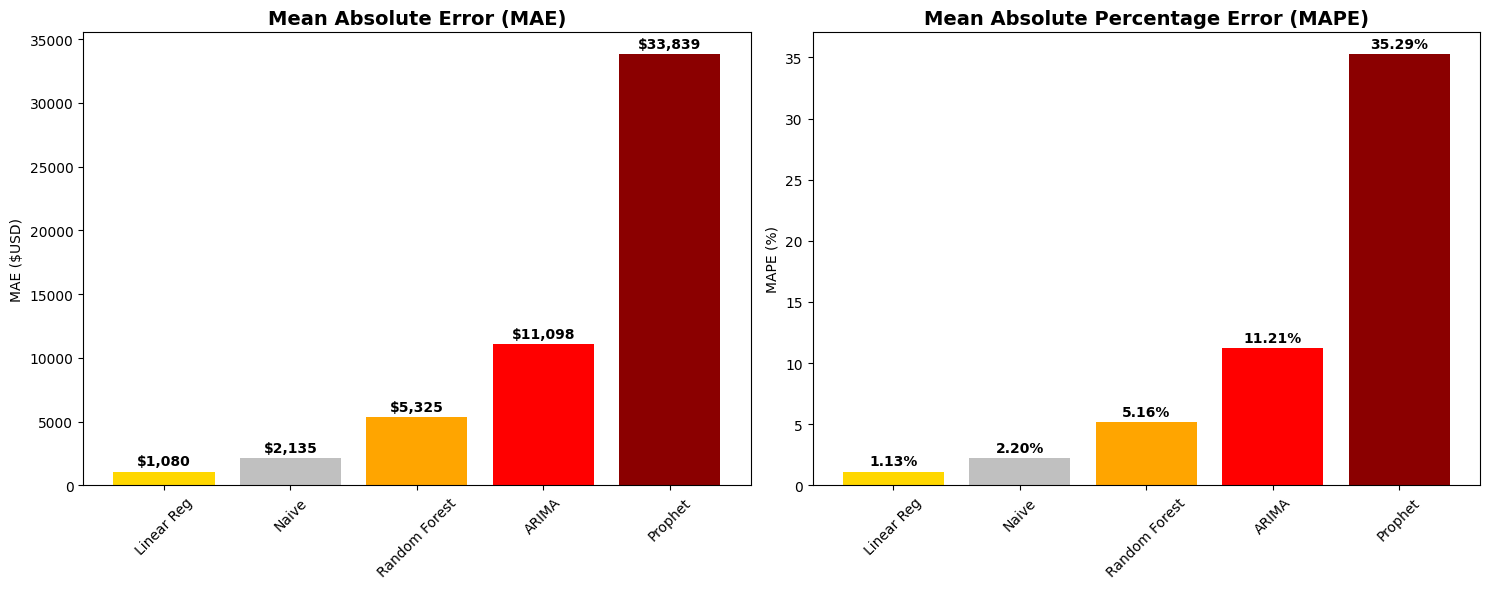

In [182]:
# Side-by-side Model Comparison Charts
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

models = ['Linear Reg', 'Naive', 'Random Forest', 'ARIMA', 'Prophet']
mae_values = [1080, 2135, 5325, 11098, 33839]
mape_values = [1.13, 2.20, 5.16, 11.21, 35.29]

# Chart 1: MAE comparison
bars1 = ax1.bar(models, mae_values, color=['gold', 'silver', 'orange', 'red', 'darkred'])
ax1.set_title('Mean Absolute Error (MAE)', fontsize=14, fontweight='bold')
ax1.set_ylabel('MAE ($USD)')
ax1.tick_params(axis='x', rotation=45)

# Add MAE value labels
for bar, value in zip(bars1, mae_values):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 500, 
             f'${value:,}', ha='center', fontweight='bold')

# Chart 2: MAPE comparison
bars2 = ax2.bar(models, mape_values, color=['gold', 'silver', 'orange', 'red', 'darkred'])
ax2.set_title('Mean Absolute Percentage Error (MAPE)', fontsize=14, fontweight='bold')
ax2.set_ylabel('MAPE (%)')
ax2.tick_params(axis='x', rotation=45)

# Add MAPE value labels
for bar, value in zip(bars2, mape_values):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{value:.2f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

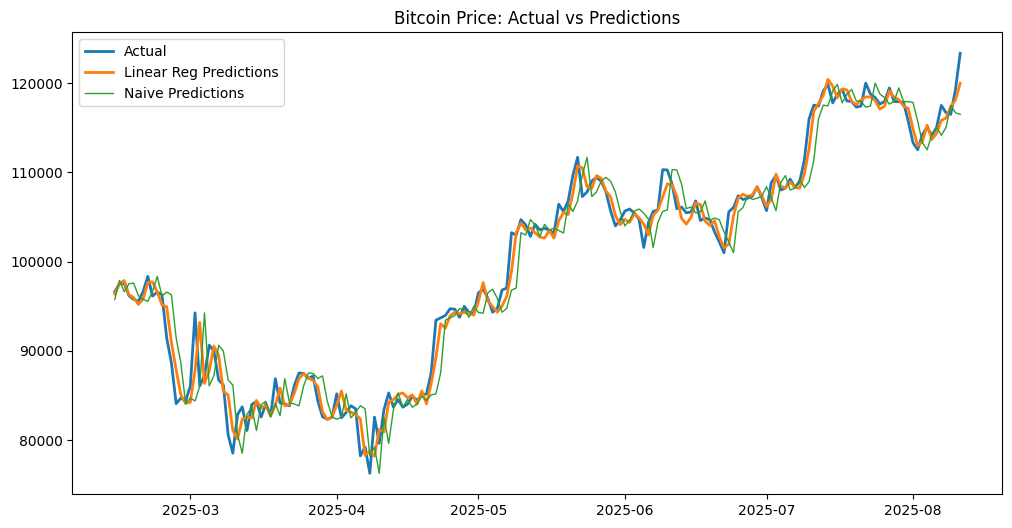

In [183]:
# Show actual vs predicted over time
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual', linewidth=2)
plt.plot(y_test.index, lr_predictions, label='Linear Reg Predictions', linewidth=2)
plt.plot(y_test.index, naive_predictions, label='Naive Predictions', linewidth=1)
plt.title('Bitcoin Price: Actual vs Predictions')
plt.legend()
plt.show()

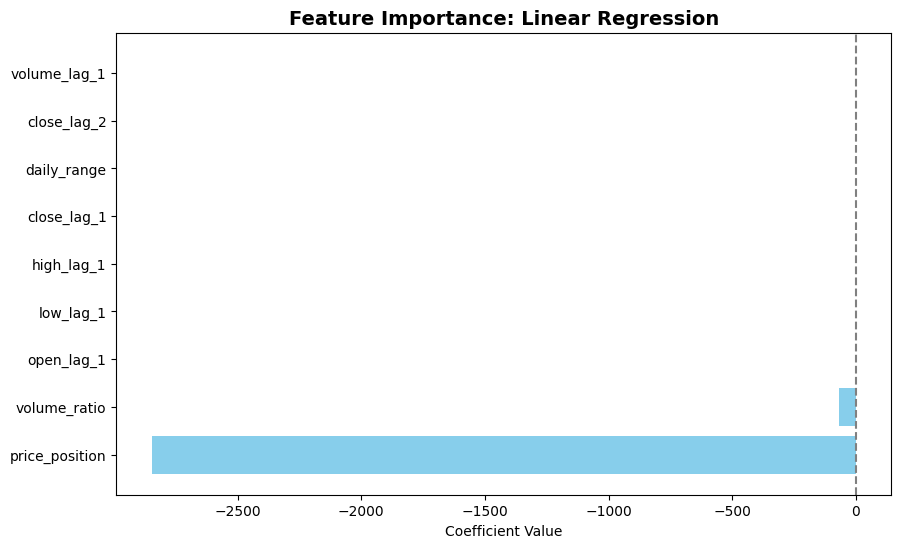

In [184]:
# Feature importance for Linear Regression
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color='skyblue')
plt.title('Feature Importance: Linear Regression', fontsize=14, fontweight='bold')
plt.xlabel('Coefficient Value')
plt.axvline(0, color='grey', linestyle='--')
plt.show()

=== ORGANIZING EXISTING RESULTS ===
Results organized from existing calculations

=== TRAIN/TEST SPLIT INFORMATION ===
Training data: 909 rows
Testing data: 180 rows
Split ratio: 83.5% train, 16.5% test
Train period: 2022-08-19 to 2025-02-12
Test period: 2025-02-13 to 2025-08-11

 Predictions saved to 'model_predictions_comparison.csv'


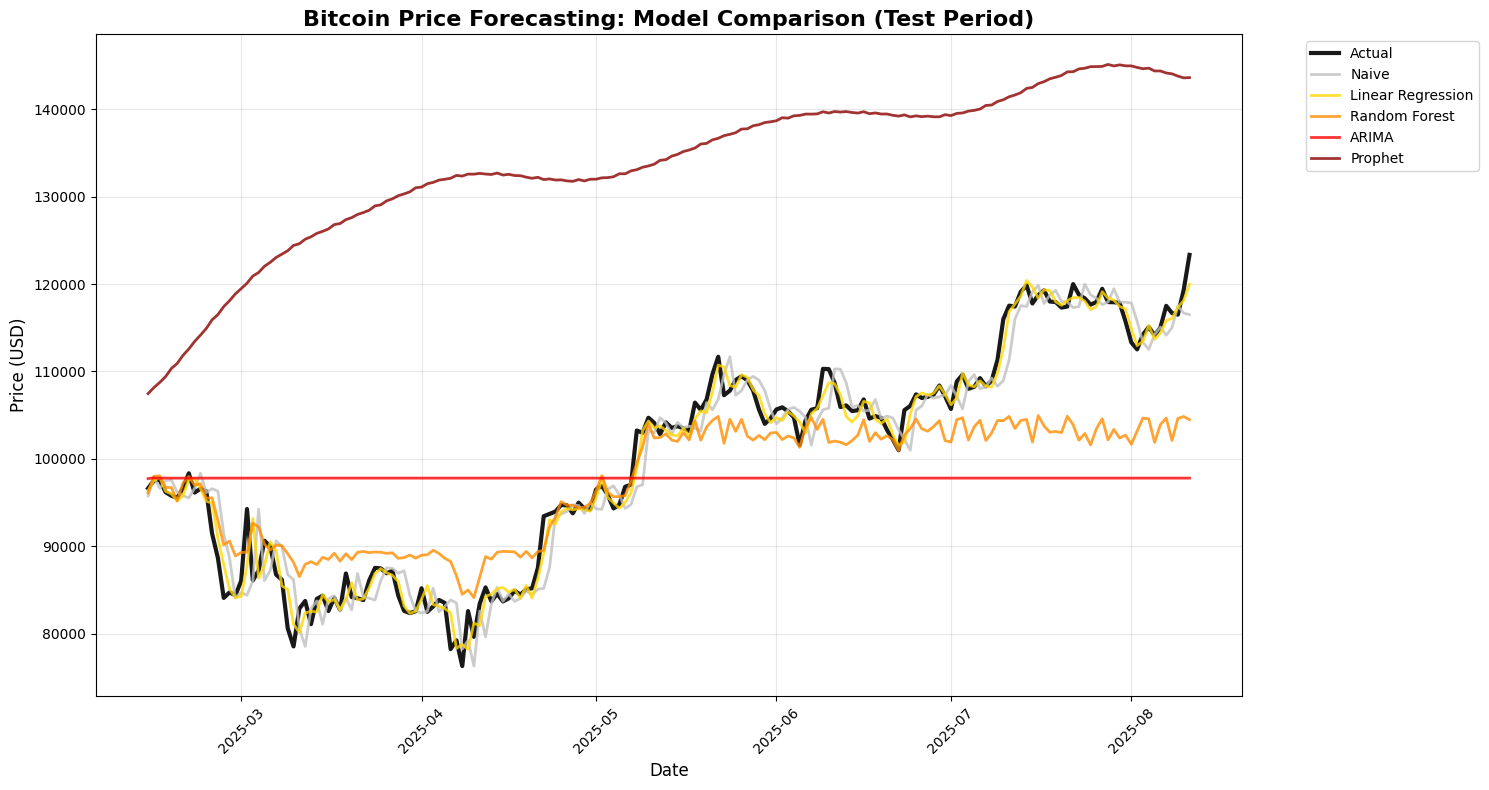

 Overlay chart saved as 'model_comparison_overlay.png'
 Performance summary saved to 'model_performance_results.csv'

=== FINAL RESULTS SUMMARY ===
 Rank             Model          MAE         RMSE      MAPE
    1             Naive  2134.995269  2898.970320  2.199874
    2 Linear Regression  1079.603966  1597.353516  1.132128
    3     Random Forest  5325.380540  7073.816305  5.161134
    4             ARIMA 11097.901566 12597.781152 11.206601
    5           Prophet 33838.992757 35022.523050 35.291649

=== FILES SAVED ===
1. model_predictions_comparison.csv
2. model_comparison_overlay.png
3. model_performance_results.csv


In [185]:
# Step 1: Organize your existing results into a list format
print("=== ORGANIZING EXISTING RESULTS ===")

# Create results list from your already calculated metrics
results = []
results.append(['Naive', mae_naive, rmse_naive, mape_naive])
results.append(['Linear Regression', mae_lr, rmse_lr, mape_lr])
results.append(['Random Forest', mae_rf, rmse_rf, mape_rf])
results.append(['ARIMA', mae_arima, rmse_arima, mape_arima])
results.append(['Prophet', mae_prophet, rmse_prophet, mape_prophet])

print("Results organized from existing calculations")

# Step 2: Print train/test counts
print(f"\n=== TRAIN/TEST SPLIT INFORMATION ===")
print(f"Training data: {len(train_data)} rows")
print(f"Testing data: {len(test_data)} rows") 
print(f"Split ratio: {len(train_data)/len(model_data):.1%} train, {len(test_data)/len(model_data):.1%} test")
print(f"Train period: {train_data.index[0].date()} to {train_data.index[-1].date()}")
print(f"Test period: {test_data.index[0].date()} to {test_data.index[-1].date()}")

# Step 3: Create predictions comparison dataframe
predictions_comparison = pd.DataFrame({
    'Date': test_data.index,
    'Actual': y_test.values,
    'Naive': naive_predictions.values,
    'Linear_Regression': lr_predictions,
    'Random_Forest': rf_predictions,
    'ARIMA': arima_forecast,
    'Prophet': prophet_predictions
})

# Save predictions to CSV
predictions_comparison.to_csv('model_predictions_comparison.csv', index=False)
print(f"\n Predictions saved to 'model_predictions_comparison.csv'")

# Step 4: Create overlay comparison chart
plt.figure(figsize=(15, 8))

# Plot actual prices (thick black line)
plt.plot(predictions_comparison['Date'], predictions_comparison['Actual'], 
         color='black', linewidth=3, label='Actual', alpha=0.9)

# Plot all model predictions with different colors
colors = ['#C0C0C0', '#FFD700', '#FF8C00', '#FF0000', '#8B0000']  # Silver, Gold, Orange, Red, DarkRed
models = ['Naive', 'Linear_Regression', 'Random_Forest', 'ARIMA', 'Prophet']
labels = ['Naive', 'Linear Regression', 'Random Forest', 'ARIMA', 'Prophet']

for model, color, label in zip(models, colors, labels):
    plt.plot(predictions_comparison['Date'], predictions_comparison[model], 
             color=color, linewidth=2, label=label, alpha=0.8)

plt.title('Bitcoin Price Forecasting: Model Comparison (Test Period)', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

# Save the overlay chart
plt.savefig('model_comparison_overlay.png', dpi=300, bbox_inches='tight')
plt.show()
print(f" Overlay chart saved as 'model_comparison_overlay.png'")

# Step 5: Save performance summary
performance_summary = pd.DataFrame(results, columns=['Model', 'MAE', 'RMSE', 'MAPE'])
performance_summary['Rank'] = range(1, len(performance_summary) + 1)
performance_summary = performance_summary[['Rank', 'Model', 'MAE', 'RMSE', 'MAPE']]

# Save performance results
performance_summary.to_csv('model_performance_results.csv', index=False)
print(f" Performance summary saved to 'model_performance_results.csv'")

# Display final summary
print(f"\n=== FINAL RESULTS SUMMARY ===")
print(performance_summary.to_string(index=False))

print(f"\n=== FILES SAVED ===")
print(f"1. model_predictions_comparison.csv")
print(f"2. model_comparison_overlay.png") 
print(f"3. model_performance_results.csv")